In [1]:
__version__ = '20180810' #Revised version
#__version__ = '20180806' #Launched version

## Imports and setup
We import all modules required for this notebook

In [2]:
# std. lib
import sys
sys.path.append('../../hypercat')
import warnings
warnings.filterwarnings('ignore')

# 3rd party
import pylab as plt
import numpy as np

# hypercat
import hypercat
import plotting
import ioops
import psf
import obsmodes
import imageops


In [5]:
###----------------HDF file dir-------------------###
#hdffile = '/YOUR_HDF_FILEPATH/hypercat_20180417.hdf5'  #For the public version
hdffile = '/Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5' #Kohei's local dir
#hdffile = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20180417.hdf5'

# Imaging 'Observation'
In this notebook we will describe how to obtain the 'observed' image based on the actual set of telescopes/instruments. Let's first prepare the target source: NGC 1068, which was already introduced in `hypercatbasics.ipynb`. 

In [6]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='onthefly')

Opening HDF5 file: /Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (693.51 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, 13.000, 14.000, 15.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [ 10.000 -

Then, application of the best fitting parameters of NGC 1068 to produce `sky` image.Our target wavelength now is L band (=3.45 $\mu$m).

In [7]:
#Set of best torus parameters obtained from the SED fitting (from Lopez-Rodriguet al. 2018)
sig, i, Y, N, q, tv, wave = 43, 75, 18, 4, 0.08, 70, 3.45
vec = (sig, i, Y, N, q, tv, wave) #The order of the parameter set is also important...

In [8]:
#list of the parameters
Lbol = '1.6e45 erg/s' 
D = '14.4 Mpc'
PA = '42 deg' 
objectname = 'ngc1068' 

In [9]:
ngc1068 = hypercat.Source(imgcube,luminosity=Lbol,distance=D,pa=PA,objectname=objectname)
sky = ngc1068(vec,total_flux_density='3.506 Jy')  #Flux density at wave=2.2, 3.45 um is from Alonso-Herrero et al. (2001)

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.


Please make sure that you have included the appropriate flux density at the specified wavelength in the `total_flux_density`.  

Let's quickly look at the `sky` image.

Plotting panel (0,0)


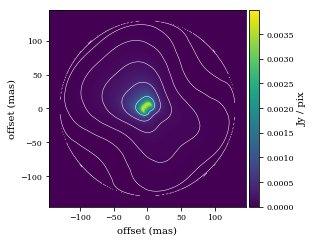

In [10]:
plotting.multiplot(sky,contours='log');

Now you are ready to obtain the simulated observation image, which is the goal of this Section.

# Imaging based on the actual telescope pupils

Here we introduce how to obtain the observed image one by one.

## Pupil image

First, let's try to look at the telescope pupil image you want to observe. We need the set of parameters necessary for obtaining the pupil image.

In [11]:
#dictionary necessary for psf.getPupil function
psfdict = {'psfmode':'pupil', 'telescope':'TMT'}

Then, let's obtain the pupil image using `psf.getPupil`

In [12]:
pupil, pupilheader = psf.getPupil(psfdict)

Then let's plot.

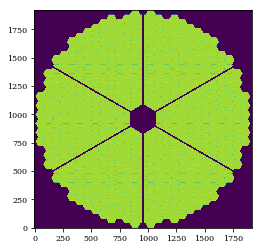

In [13]:
plt.imshow(pupil, origin='lower')

Hypercat provides other pupil images and the list can be seen in '../../data/pupils.json'.

## Get the PSF
We also provide the PSF once the telescope and the target wavelength are specified.

In [14]:
#disctionary necessary for PSF
psfdict = {'psfmode':'pupil', 'telescope':'TMT', 'wavelength':np.str(wave)+'micron'}
#get the PSF information
PSF = psf.getPSF(psfdict)

Pixel scale in PSF image is:  23.74518728850825  mas per pixel


Let's plot the PSF.

Plotting panel (0,0)


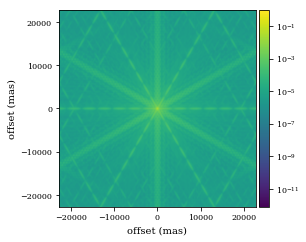

In [15]:
plotting.multiplot(PSF); 

We now see the beautiful PSF pattern based on the actual pupil of TMT.

## Simulated Observation

Then, let's obtain the simulated observation using the provided PSF.
`obsmodes` gives you the observation mode of `.Imaging` and `.Interferometry`.

In [16]:
#dictionary necessary for simulated observations
psfdict = {'psfmode':'pupil', 'telescope':'TMT', 'wavelength':np.str(wave)+'micron', 'pixelscale_detector':'Nyquist'}
#Create the Instrument for the observations
obs = obsmodes.Imaging(psfdict)

Pixel scale in PSF image is:  23.74518728850825  mas per pixel


Now, `obs` contains observation mode of imaging at 3.45 $\mu$m onboard TMT with the Nyquist sampling pixelscale.

Now we have `sky` (target model image) and `obs` (observational mode). Let's get the observed image at the sky of NGC~1068 using `obs.observe`

In [17]:
#perform the observations
#obs.observe(sky)
ngc1068_obs, PSF, PSF_resampled = obs.observe(sky)
#obs.observe(sky,psfdict=psfdict)

self.PSF: Computed pixelscale from pupil =  23.74518728850825 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20738 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (11.8726 mas) was slightly adjusted due to discretization (now 11.6442 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (11.8726 mas) was slightly adjusted due to discretization (now 11.6392 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


The [WARNING] messages about adjusted pixelscales are due to image discretization. This is the intended behaviour.

### Addition of noise

### Image Deconvolution

Finally, let's deconvolve the observed image using the obtained PSF stored in `PSF_resampled`. 

In [18]:
#deconvolve observations
ngc1068_deconv = PSF_resampled.deconvolve(ngc1068_obs)

This gives you the final observed image after the PSF deconvlution.

## Comparison of each image

Let's take a look of each image we obtained.

Text(0.5,1,'Deconvolved observations')

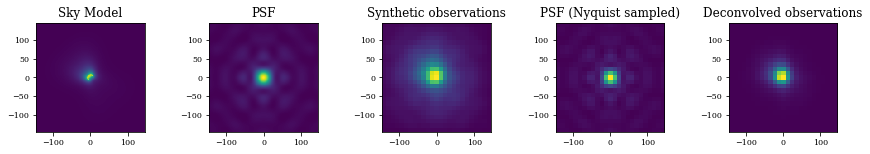

In [24]:
fig, axs = plt.subplots(1,5,figsize=(15,2))
ax = axs.flatten()

d=sky.FOV.value/2
extent=(-d,d,-d,d)
ax[0].imshow(sky.I,origin='lower', extent=extent)
ax[1].imshow(PSF.I,origin='lower', extent=extent)
ax[2].imshow(ngc1068_obs.I,origin='lower', extent=extent)
ax[3].imshow(PSF_resampled.I,origin='lower', extent=extent)
ax[4].imshow(ngc1068_deconv,origin='lower', extent=extent)

#titles
ax[0].set_title('Sky Model')
ax[1].set_title('PSF')
ax[2].set_title('Synthetic observations')
ax[3].set_title('PSF (Nyquist sampled)')
ax[4].set_title('Deconvolved observations')

From left to right, the figures show 1) Sky model image, 2) PSF image obtained from the pupil of TMT, 3) the convolved observed image of 1) and 2), 4) Pizelized PSF image, 5) Deconveld observed image.

Pixel scale in PSF image is:  23.74518728850825  mas per pixel
self.PSF: Computed pixelscale from pupil =  23.74518728850825 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20738 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (11.8726 mas) was slightly adjusted due to discretization (now 11.6442 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (11.8726 mas) was slightly adjusted due to discretization (now 11.6392 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


Text(0.5,1,'Deconvolved SNR=10')

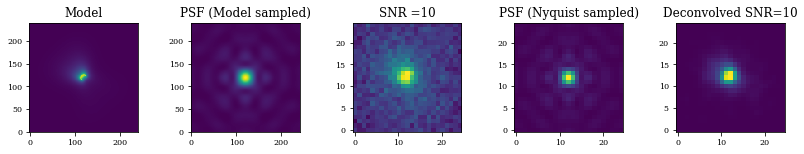

In [20]:
#perform the observations with a level of noise
SNR = 10
ngc1068_noisy, PSF, PSF_resampled = obs.observe(sky,snr=SNR, peakfraction=.5, psfdict=psfdict)
#deconvolve observations
ngc1068_deconv_noisy = PSF_resampled.deconvolve(ngc1068_noisy)

#Plotting
fig, axs = plt.subplots(1,5,figsize=(14,2))
ax = axs.flatten()

ax[0].imshow(sky.I,origin='lower')
ax[1].imshow(PSF.I,origin='lower')
ax[2].imshow(ngc1068_noisy.I,origin='lower')
ax[3].imshow(PSF_resampled.I,origin='lower')
ax[4].imshow(ngc1068_deconv_noisy,origin='lower')

#titles
ax[0].set_title('Model')
ax[1].set_title('PSF (Model sampled)')
ax[2].set_title('SNR ='+np.str(SNR))
ax[3].set_title('PSF (Nyquist sampled)')
ax[4].set_title('Deconvolved SNR='+np.str(SNR))

In [20]:
idxpeak1d = np.argmax(PSF.I)
idx2d = np.unravel_index(idxpeak1d,PSF.I.shape)
psf_radialprofile = imageops.radial_profile(PSF.I,idx2d)

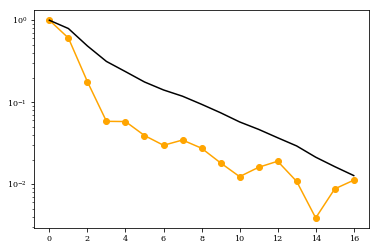

In [21]:
idxpeak1d = np.argmax(PSF_resampled.I)
idx2d = np.unravel_index(idxpeak1d,PSF_resampled.I.shape)
psf_radialprofile = imageops.radial_profile(PSF_resampled.I,idx2d)
ima_radialprofile = imageops.radial_profile(ngc1068_obs.I,idx2d)


plt.plot(psf_radialprofile/psf_radialprofile.max(),'o-',color='orange')
plt.plot(ima_radialprofile/ima_radialprofile.max(),'-',color='black')

plt.yscale('log')